# COVID Hospital mapping for Ethiopia

In [7]:
import numpy as np
import rasterio
import pandas as pd
from rasterio.windows import Window
from matplotlib import pyplot
import matplotlib.pyplot as plt
import geopandas as gdp
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import box
import requests #http framework to make mhvpl requests for routes
import json # handle response as json
from geopy.distance import vincenty
import pickle
import preprocessing

log = logging.getLogger(__name__)

## Prepare population data

In [6]:
CRS ='epsg:4326'
LOCATION = 'ethiopia'
DATAPATH = 'data/' + LOCATION
RAWFILEPATH  = DATAPATH +  '/raw'
PROCESSEDFILEPATH = DATAPATH + '/processed'
RESULTSFILEPATH = DATAPATH + '/results'

# Facebooks HRSL dataset
map_file = RAWFILEPATH+"/population_eth_2018-10-01.tif"


In [ ]:
def get_pop(map_file,left_x,top_y,window,plot=False):
    """
    get_pop(raster filename,left_x,top_y,window,plot=False)

    Given a raster file, and row,cols ranges,
    return the lonlat of the ranges, nancount, and the nunsum

    Optionally plot the raster window [False]
    """
    right_x,bottom_y = left_x + window, top_y + window
    with rasterio.open(map_file) as src:
        left_lon, top_lat = src.xy(top_y,left_x)
        right_lon, bottom_lat = src.xy(bottom_y, right_x )
        center_lon , center_lat = (right_lon + left_lon)/2., (top_lat+bottom_lat)/2.
                             #Window(col_off, row_off, width, height)
        w = src.read(1, window=Window(left_x, top_y, window, window))
        if plot:
            pyplot.imshow(w, cmap='pink')
            pyplot.show()
        nancount=np.count_nonzero(~np.isnan(w))
        count = np.size(w)
        tot_pop=np.nansum(w)
    if count == 0:
        return {} #Out of bounds
    if tot_pop == 0 or window < 1: #Mark the window no further split.
        split=False
    else:
        split=True
    out={'window':window,
         'left_x':left_x,
         'right_x':right_x,
         'top_y':top_y,
         'bottom_y':bottom_y,
         'left_lon':left_lon,
         'top_lat':top_lat,
         'right_lon':right_lon,
         'bottom_lat':bottom_lat,
         'center_lon':center_lon ,
         'center_lat':center_lat,
         'count': count,
         'nancount':nancount,
         'tot_pop':tot_pop,
         'split': split}
    return out

In [ ]:
def split(map_file,origin,plot=False):
    """
    Split a window row in 4 parts, and return new rows results
    """
    origins=pd.DataFrame()
    window=int(origin.window/2)
    for left_x in np.arange(origin.left_x,origin.right_x,window):
        for top_y in np.arange(origin.top_y,origin.bottom_y,window):
            out=get_pop(map_file,left_x,top_y,window,plot=plot)
            if out != {}:
                origins=origins.append([out])
    return origins

In [3]:
#Initial scan the raster map with big windows
origins=pd.DataFrame()
window=2000

with rasterio.open(map_file) as src:
    a=src.xy(0,1)
    for left_x in np.arange(0,src.width,window):
        for top_y in np.arange(0,src.height,window):
            out=get_pop(map_file,left_x,top_y,window,plot=False)
            if out != {}:
                origins=origins.append([out])
        print("%i/%i\r"%(left_x,src.width),end="")

In [6]:
#Perform a splitting pass
#Run this cell as many times as you want to split the windows
print("%i regions need splitting"%len(origins[origins['split']==True]))
olen=len(origins)
for i in np.arange(olen):
    print("%i/%i\r"%(i+1,olen),end="")
    if origins.iloc[i,origins.columns.get_loc('split')] == True:
        origins.iloc[i,origins.columns.get_loc('split')]='done'
        s=split(map_file,origins.iloc[i])
        origins=origins.append(s,sort=False)
print("We now have %i regions, %i will be split in next round"%(len(origins),len(origins[origins['split']==True])))

348 regions need splitting
done.67
We now have 1959 regions, 1278 will be split in next round


In [7]:
# Keep the regions whith popluation>1
# and filter out the regions which have been split
origins=origins[origins['tot_pop']>0]
origins=origins[origins['split']!='done']
print("We have %i regions of size %i, %i with population >0"%
      (len(origins),min(origins['window']),len(origins[origins['tot_pop']>0])))

We have 1278 regions of size 1000, 1278 with population >0


In [11]:
#transform into GeoDataFrame
origins=gdp.GeoDataFrame(origins,crs='epsg:4326', geometry=[Point(xy) for xy in zip(origins['center_lon'], origins['center_lat'])])
origins.geometry=origins.apply(lambda r: box(r.left_lon, r.bottom_lat, r.right_lon, r.top_lat, ccw=False),axis=1)

In [9]:
# save shapefile
origins.to_file(driver = 'ESRI Shapefile', filename = PROCESSEDFILEPATH+'/origin.shp')

## Import hospitals

In [6]:
hospital_path = PROCESSEDFILEPATH+"/ethiopia_hospitals.shp"
df = gpd.read_file(hospital_path).to_crs(CRS)
df['lon']=df.geometry.centroid.x
df['lat']=df.geometry.centroid.y
df['name']=df['Facility n']
hospitals=df[['name','lon','lat','geometry']]
print("There are %i hospitals"%len(hospitals))

There are 151 hospital destinations


## Calculate travel times from each region to the nearest hospital

In [15]:
# prepare hospital locations to be fed into the OSRM engine as strings
hospitals_loc=";".join([str(i[1])+','+str(i[0]) for i in hospitals[['lat','lon']].values])

In [13]:
# Function to only keep the five closest hospitals to calculate the distances to
def n_closest_geodetic(destinations,origins,n_keep,verbose=False):
    """
    Given a list of origins and destinations, return the "keep" number
    of destinations that are closest geodetically to each origin.

    Input: destinations,origins <Geopandas>
    Output: destinations filtered <Geopandas>
    """
    destinations=destinations.to_crs(origins.crs)
    filtered=gdp.GeoDataFrame()

    if verbose:
        i=0
        l=len(origins.index)
    for index in origins.index:
        if verbose:
            i=i+1
            print("Doing %i of %i\r"%(i,l),end="")
        distances=destinations.distance(origins.loc[index].geometry)
        if len(distances) < n_keep:
            n_keep = len(distances)
        #query indices
        indices=np.argsort(distances.values)[:n_keep]
        values=np.sort(distances.values)[:n_keep]
        #destination indices
        d_indices=distances.index[indices]
        filtered = filtered.append(destinations.iloc[indices])

    if verbose:
        print('done')
    return filtered.append(filtered).drop_duplicates(inplace=False)

In [24]:
# List of all the hospitals which are at least for one of the origin points
# among the top "n_keep" hospitals wrt geodesic distance.
test_o = origins.sample(frac=1).reset_index(drop=True).head(5)
test_d = hospitals.sample(frac=1).reset_index(drop=True).head(10)
filtered = n_closest_geodetic(test_d,test_o,3,verbose=True)


doneg 5 of 5


In [6]:
# go in
h=hospitals.reset_index(drop=True)
o=origins.reset_index(drop=True)

In [26]:
# save the data for later usage
#SAVE
with open(PROCESSEDFILEPATH+'/'+LOCATION+'_1959-h-o.pickle', 'wb') as handle:
    pickle.dump([h,o], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [21]:
#LOAD
with open('data/ethiopia_15997-h-o.pickle', 'rb') as handle:
    h,o = pickle.load(handle)

In [25]:
# osrm server address
osrm_server="http://0.0.0.0:5000"
server=osrm_server+"/table/v1/driving/"
comma="%2C"
Sep="%3B"

batch=10
usual_origin='hospital'

origins = o
hospitals = h

buffer=10/60.  #10 minutes, in hours
overalpenalty=1.05  #5%

# create a new column in the Geodataframe for the time and initilize with -1
origins['t_'+usual_origin]=-1
origins['m_'+usual_origin]=-1

for i in np.arange(origins.shape[0]/batch):
    print("Doing batch %i, [%i,%i] of %i"
          %(i,batch*i,batch*(i+1),origins.shape[0]),end="\r")
    origins_batch=origins.iloc[int(batch*i):].head(n=batch)

    destinations=";".join([str(i[1])+','+str(i[0]) for i in origins_batch[['center_lat','center_lon']].values])
    destinations_number=origins_batch.index

    trail=".json?destinations="+\
    ';'.join([str(x) for x in np.arange(len(hospitals))])+\
    "&sources="+\
    ';'.join([str(x) for x in np.arange(len(hospitals),len(hospitals)+len(origins_batch))])

    fullurl= server+hospitals_loc+";"+destinations+trail
    counter= 0
    response = requests.get(fullurl)
    try:
        response.raise_for_status()
        durations_matrix=json.loads(response.text)['durations']

        durations=[]
        hospital_min=[]
        for origen in np.arange(np.shape(durations_matrix)[0]):
            durations+=[min(durations_matrix[origen])]
            hospital_min+=[np.argmin(durations_matrix[origen])]
        for i in np.arange(len(durations)):
            origins.loc[[destinations_number[i]], ['t_'+usual_origin]]=buffer+durations[i]/60./60.*overalpenalty
            origins.loc[[destinations_number[i]], ['m_'+usual_origin]]=hospital_min[i]

    except:
        counter = counter+1
        continue

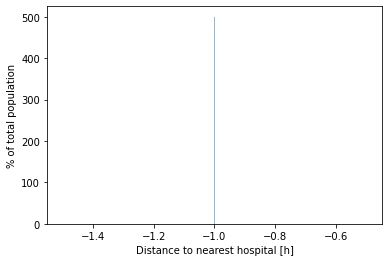

In [24]:
%matplotlib inline
plt.figure()
origins['t_'+usual_origin].plot.hist(alpha=0.5,bins=500,cumulative=False,density=True)
plt.ylabel('% of total population')
plt.xlabel('Distance to nearest '+usual_origin+' [h]')
plt.savefig('travel_time_dist.pdf')
plt.show()

In [27]:
origins.to_file(RESULTSFILEPATH+'/origins_15997_hospitals_final.geojson', driver='GeoJSON')
origins.to_file(RESULTSFILEPATH+'origins_15997_hospitals_final.shp', driver='ESRI Shapefile')
j

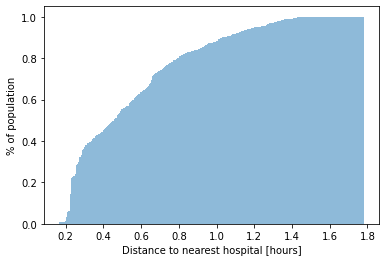

In [110]:
plt.figure()
origins['t_'+usual_origin].plot.hist(alpha=0.5,bins=500,cumulative=True,density=True,weights=origins['tot_pop'])
plt.ylabel('% of population')
plt.xlabel('Distance to nearest '+usual_origin+' [hours]')
plt.show()

In [108]:
for i in np.arange(10,101,10):
    print("El %i%% de la población en Asturias tarda %2.1f minutos en llegar al destino: %s"%
         (i,np.percentile(weight_array(origins['t_'+usual_origin].values*60, origins['tot_pop'].values), i),usual_origin))

NameError: name 'weight_array' is not defined

In [ ]:
lejos=origins[origins['t_'+usual_origin]>1].sort_values(by='t_'+usual_origin,ascending=False)

for index,lugar in lejos.head(n=5).iterrows():
    print("%i personas en %s tardan %2.1f horas en llegar al destino: %s"%
         (lugar["POBLACION"],lugar["NOMBRE"],lugar["t_"+usual_origin],usual_origin))
    get_route_link([hospitales.loc[lugar['m_hospital']]['lon'],hospitales.loc[lugar['m_hospital']]['lat']],
                   [lugar['lon'],lugar['lat']])


origins.to_file("data/origins.geojson", driver="GeoJSON")